In [7]:
import numpy as np
import scipy as scp
from pyedflib import highlevel
import pyedflib as plib
import matplotlib.pyplot as plt
import mne as mne
from scipy import linalg as la
from sklearn.linear_model import Perceptron
import os

In [8]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles


#subfolders, datafiles = run_fast_scandir('/content/drive/MyDrive/files', [".edf"])
subfolders, datafiles = run_fast_scandir('../dataset/files', [".edf"])
#subfolders, eventfiles = run_fast_scandir('/content/drive/MyDrive/files', [".event"])

subfolders.sort()
datafiles.sort()
print(subfolders[:3])
print(datafiles[:3])

['../dataset/files\\S001', '../dataset/files\\S002', '../dataset/files\\S003']
['../dataset/files\\S001\\S001R01.edf', '../dataset/files\\S001\\S001R02.edf', '../dataset/files\\S001\\S001R03.edf']


<h1>Criação do filter bank - próximos 2 blocos</h1>

In [9]:
min_freq = 4
max_freq = 40

n_bands = int((max_freq - min_freq)/2)

bands = []
f1 = 4
f2 = 8

for i in range(1,n_bands):
  bands.append([f1,f2])
  f1+=2
  f2+=2
print("Bandas de frequência: ", bands)

Bandas de frequência:  [[4, 8], [6, 10], [8, 12], [10, 14], [12, 16], [14, 18], [16, 20], [18, 22], [20, 24], [22, 26], [24, 28], [26, 30], [28, 32], [30, 34], [32, 36], [34, 38], [36, 40]]


In [10]:
mne.set_log_level('INFO') #  Suprimir os logs das funções da biblioteca/ it can be either DEBUG, INFO, WARNING, ERROR, or CRITICAL

filter_design = 'firwin2'
ska = 'edge'

raw = mne.io.read_raw_edf(datafiles[0], preload = False)
channels = raw.ch_names
n_channels = len(channels)

for band in bands:

  filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],l_freq=band[0], h_freq=band[1], fir_design = filter_design) # Criar filtro. É preciso dados como parâmetro
  #mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(0.5, 60)) # Plot do filtro

mne.set_log_level('WARNING')

Extracting EDF parameters from f:\OneDrive\Ambiente de Trabalho\neuro\eegaming\dataset\files\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 529 samples (3.306 s)

Setting up band-pass filter from 6 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 1

In [11]:
def check_event_count(event_data):

  '''
  Função que:
  - Faz prints do número de trials/blocos de cada classe de movimento. 

  ---------------------
  Input:
  - event_data: Objeto com todos os blocos de dados

  '''

  print("Rest: ", event_data["rest"].__len__())
  print("Right Fist: ", event_data["right_fist"].__len__())
  print("Left Fist: ", event_data["left_fist"].__len__())
  print("Both Fists: ", event_data["both_fists"].__len__())
  print("Both Feet: ", event_data["both_feet"].__len__())
     

''' Commit "Test/Train split: 84144ec" tem todo o código com os prints e plots desta função relacionados com os eventos'''

def load_subject_data(subject, datafiles, bands, tstart, tstop):

  '''
  Função que:
  - Carrega todos os dados contínuos de um participante da base de dados.
  - Filtra os dados contínuos.
  - Reatribui as labels para separar melhor as 5 classes de EEG da base de dados.
  - Agrupa e concatena os blocos dados dos vários trials (bloco com cerca de 4.2s de dados que 
  corresponde à execução de uma classe de movimento) de ficheiros 
  diferentes a partir das novas labels.
  - Segmenta os dados 

  ---------------------
  Input:
  subject: Caminho para o diretório onde estão todos os ficheiros de um participante 
  datafiles: Caminhos de todos os ficheiros edf (todos os participantes) da base de dados
  tstart: Instante no tempo (s) da primeira amostra do segmento de um bloco a ser analisado
  tstop: Instante no tempo (s) da última amostra do segmento de um bloco a ser analisado
  
  ---------------------
  Output:
  subject_epochs: Objeto com todos os blocos de dados concatenados e com toda a informção relativamente
  aos eventos de cada classe
  '''

  trials = []
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)

  eachBand_epochs = []
  
  for band in bands: # Filtrar os dados nas várias bandas de frequência
    print(f"Filtragem na banda de frequências: {band[0]} - {band[1]} Hz")

    all_trials = [] # Variável com todos os blocos
    
    for count, trial  in enumerate(trials):
      if count > 1: # Avança os dois primeiros trials correspondentes ao rest
        raw_data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório
        
        ch_names = raw_data.ch_names # Elétrodos
        fs =  raw_data.info.get('sfreq') # Frequência de amostragem
        annotations = raw_data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados

        trial_type1 = [3, 4, 7, 8, 11, 12]
        trial_type2 = [5, 6, 9, 10, 13, 14]

        # Atribuição das labels corretas aos eventos de cada trial
        #--------------- TOMÁS: tive de adaptar a linha seguinte por causa da maneira como tenho o diretório (../ yada yada, cria uma separação para cada ponto,
        # então fica algo tipo [''] [''] ['actual diretorio'] ['edf']) -----------------------------------------
        trial_number = int(trial.split('.')[2][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
        
        if trial_number in trial_type1:
          event_ids = {'T0': 1, 'T1': 2, 'T2': 3} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
          epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "right_fist/block": 3}
        elif trial_number in trial_type2:
          event_ids = {'T0': 1, 'T1': 4, 'T2': 5}
          epoch_event_ids = {"rest/block": 1, "both_fists/block": 4,"both_feet/block": 5}
        else:
          event_ids = {'T0': 1} # Dois primeiros trials de EEG

        # Filtragem

        filtered_data = raw_data.copy().filter(band[0], band[1], fir_design=filter_design, skip_by_annotation=ska) 
        
        # Mapeamento dos eventos com as novas labels

        events = mne.events_from_annotations(filtered_data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
        
        # Agrupamento dos blocos do mesmo id (epoching)

        epochs = mne.Epochs(filtered_data, events[0], event_id = epoch_event_ids, tmin = tstart, tmax = tstop, detrend = 1, baseline = None, preload = True)
        
        all_trials.append(epochs)
        
    # Concatenação de todos os blocos (trials) de uma banda de frequências

    subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')
    equalized_subject_epochs = subject_epochs.equalize_event_counts()[0]

    eachBand_epochs.append(equalized_subject_epochs)
    
  return eachBand_epochs

In [12]:
# Carregar dados de todos os participantes
# Equaliza o nº de trials em todas as classes. A classe rest tinha muitos mais trials por exemplo.
# O bom balanceamento de classes é importante durante a classificação

mne.set_log_level('CRITICAL')

all_subject_epochs = []

for id, subject in enumerate([subfolders[0]]):
  print("---------------------------------------------")
  print("Ler dados do participante: ", id+1)
  all_subject_epochs.append(load_subject_data(subject, datafiles, bands, 0.5, 3))

mne.set_log_level('WARNING')

---------------------------------------------
Ler dados do participante:  1
Filtragem na banda de frequências: 4 - 8 Hz
Filtragem na banda de frequências: 6 - 10 Hz
Filtragem na banda de frequências: 8 - 12 Hz
Filtragem na banda de frequências: 10 - 14 Hz
Filtragem na banda de frequências: 12 - 16 Hz
Filtragem na banda de frequências: 14 - 18 Hz
Filtragem na banda de frequências: 16 - 20 Hz
Filtragem na banda de frequências: 18 - 22 Hz
Filtragem na banda de frequências: 20 - 24 Hz
Filtragem na banda de frequências: 22 - 26 Hz
Filtragem na banda de frequências: 24 - 28 Hz
Filtragem na banda de frequências: 26 - 30 Hz
Filtragem na banda de frequências: 28 - 32 Hz
Filtragem na banda de frequências: 30 - 34 Hz
Filtragem na banda de frequências: 32 - 36 Hz
Filtragem na banda de frequências: 34 - 38 Hz
Filtragem na banda de frequências: 36 - 40 Hz


<h1>Exemplo de handling destes dados


Equalização de eventos: 
Rest:  44
Right Fist:  44
Left Fist:  44
Both Fists:  44
Both Feet:  44


['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
Indices:  [31 33 35  1  3  5  8 10 12 15 17 19 48 50 52 61]
Condições:  {'rest/block': 1, 'left_fist/block': 2, 'right_fist/block': 3, 'both_fists/block': 4, 'both_feet/block': 5}

Blocos:  [[   672      0      3]
 [  1328      0      1]
 [  2000      0      2]
 [  3328      0      2]
 [  4656      0      3]
 [  5312      0      1]
 [  5984      0      3]
 [  6640      0      1]
 [  7

C:\Users\frank\AppData\Local\Temp\ipykernel_15744\2909259823.py:20: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  subject_epochs["right_fist"].plot_image(picks=[chan[0]])


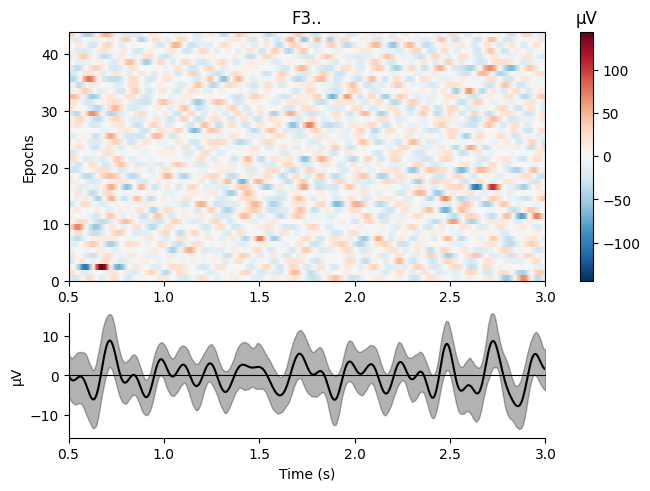

[<Figure size 640x480 with 3 Axes>]

In [13]:
subject_epochs = all_subject_epochs[0][0]

print("\nEqualização de eventos: ")
check_event_count(subject_epochs)
print("\n")

# Seleção de elétrodos
print(channels)
chan = mne.pick_channels(channels, include = ['F3..', 'Fz..','F4..', 
                                              'Fc3.', 'Fcz.','Fc4.',
                                                'C3..','Cz..','C4..',
                                                'Cp3.', 'Cpz.', 'Cp4.',
                                                'P3..', 'Pz..', 'P4..',
                                                'Oz..' ])
print("Indices: ", chan)

#dir(subject_epochs)
print("Condições: ",subject_epochs.event_id)
print("\nBlocos: ",subject_epochs.events)
subject_epochs["right_fist"].plot_image(picks=[chan[0]])

<h2> Função que vem a seguir, antes do csp, avalia se achas necessario/ se da jeito

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
def split_EEG(subject_EEG, classes, percent_train=0.8):
  
  n_trials, _, _ = np.shape(subject_EEG)
  n_train = round((n_trials/len(classes)) * percent_train)
  n_test = int((n_trials/len(classes)) - n_train)

  # print("Nº de trials: ", n_trials)
  # print("Nº de trials para treinar (por classe): ", n_train)
  # print("Nº de trials para teste (por classe): ", n_test)

  epochs_train = []
  epochs_test = []

  #shuffle trials. O miguel nao fazia. N sei se é sposto n fazer. o on missmatch com raise avisa que n esta por ordem cronologica
  np.random.seed(42)
  ids = np.random.permutation(n_trials//len(classes))
  ids_train = ids[:n_train]
  ids_test = ids[n_train:n_train+n_test]

  for class_key, _ in classes.items():
    epochs_train.append(subject_EEG[class_key][ids_train]._data)
    epochs_test.append(subject_EEG[class_key][ids_test]._data)

  #conver to numpy array
  epochs_train = np.array(epochs_train)
  epochs_test = np.array(epochs_test)

  #filter only channels of interest
  epochs_train = epochs_train[:, :, chan, :]
  epochs_test = epochs_test[:, :, chan, :]
  
  print("Shape dos dados de treino: ", epochs_train.shape)
  print("Shape dos dados de teste: ", epochs_test.shape)

  return epochs_train, epochs_test

# Split Test/Train

classes = subject_epochs.event_id

all_train_data = []
all_test_data = []

for subject in range(len(all_subject_epochs)):
  #for subject in [0]:

  bands_train_data = []
  bands_test_data = []
  print("Sujeito: ", subject+1)

  for band in range(len(bands)):
    train_data, test_data = split_EEG(all_subject_epochs[subject][band], classes, percent_train=0.8)
    bands_train_data.append(train_data)
    bands_test_data.append(test_data)

  all_train_data.append(bands_train_data)
  all_test_data.append(bands_test_data)

all_train_data = np.array(all_train_data)
all_test_data = np.array(all_test_data)

print("Shape final dos dados de treino: ", all_train_data.shape)
print("Shape final dos dados de teste: ", all_test_data.shape)

Sujeito:  1
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de t

Sujeito:  1
Banda:  1


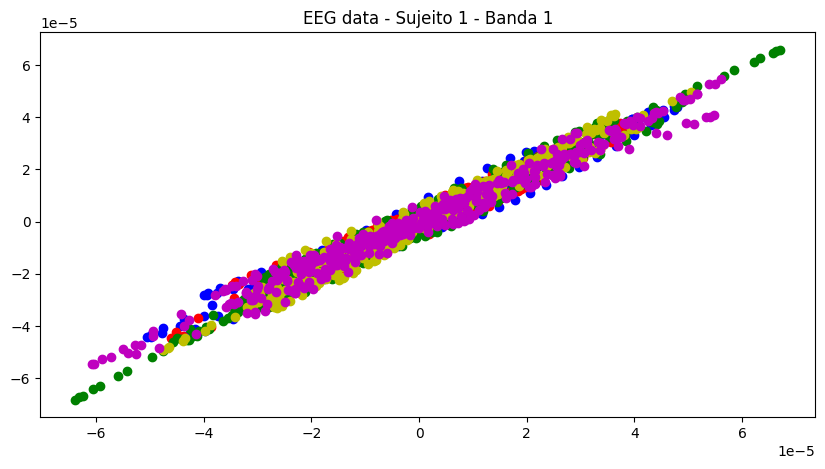

Banda:  2


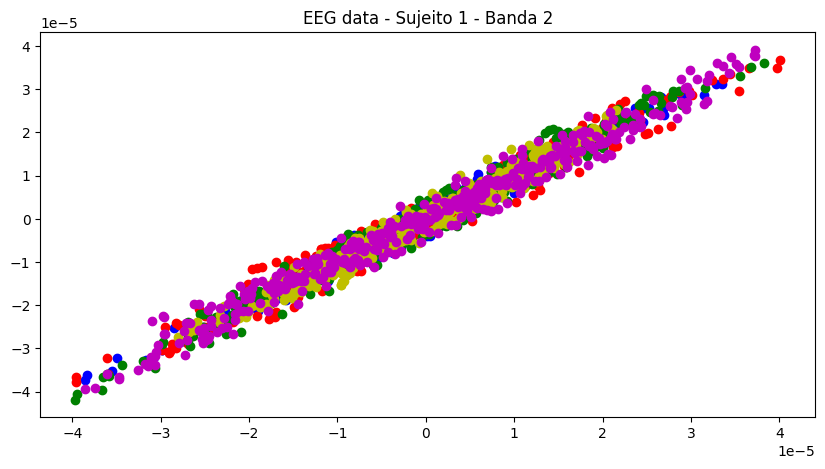

Banda:  3


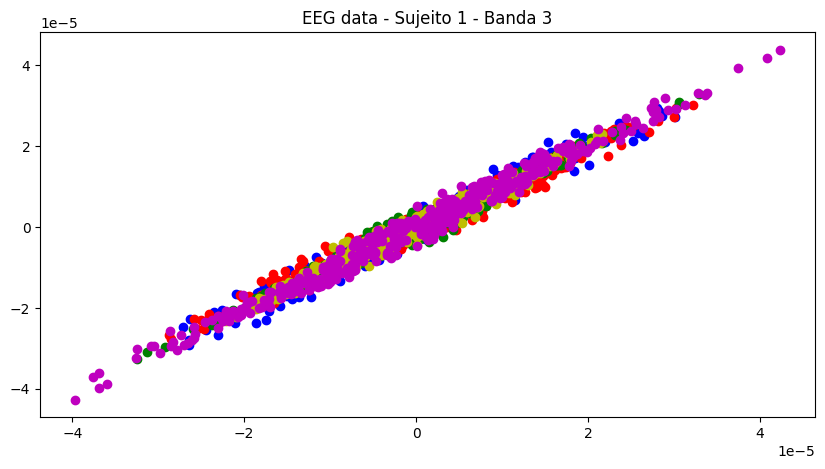

Banda:  4


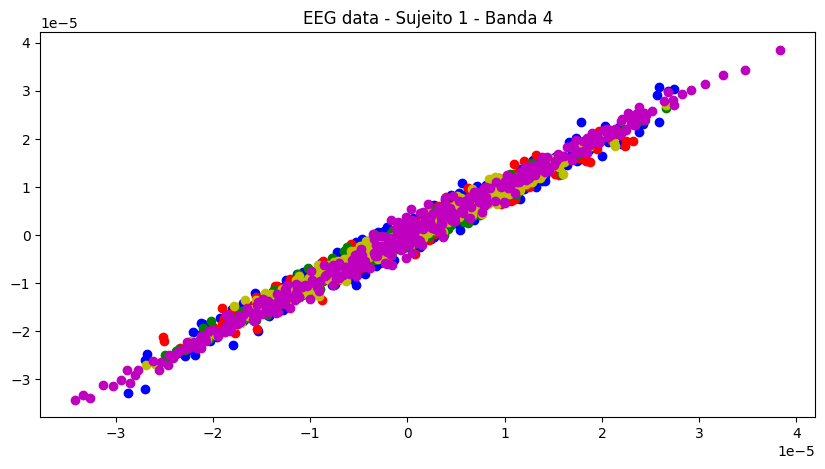

Banda:  5


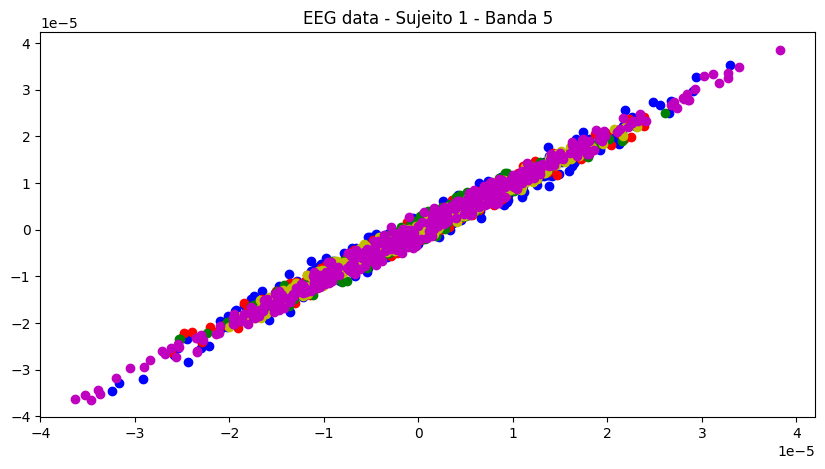

Banda:  6


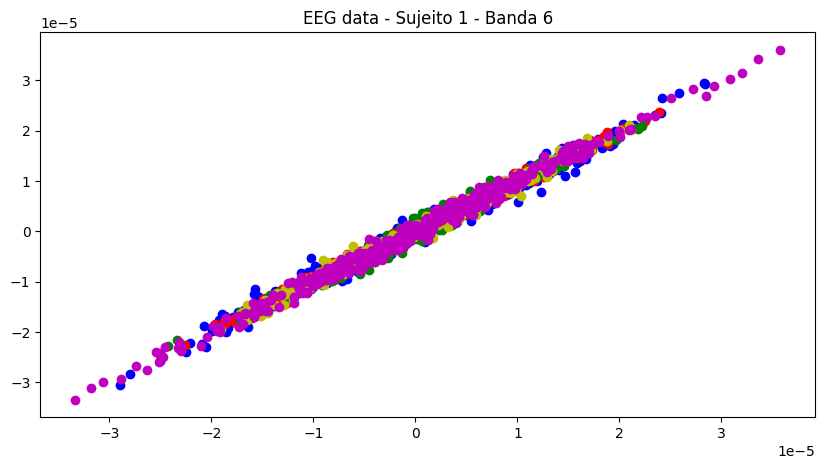

Banda:  7


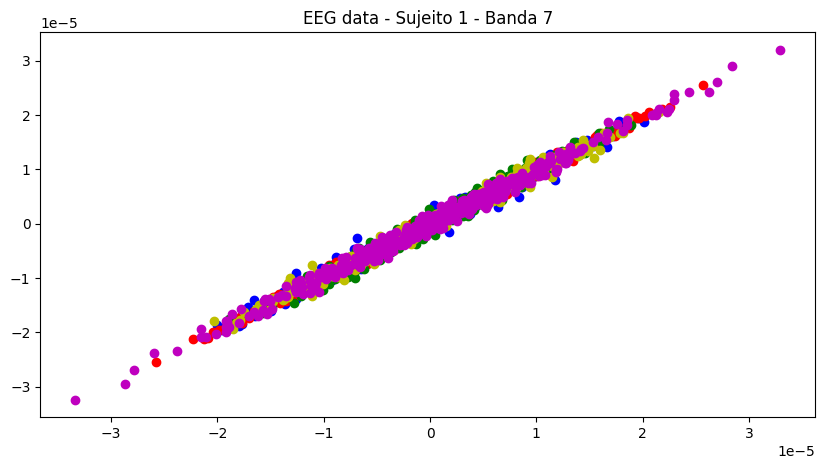

Banda:  8


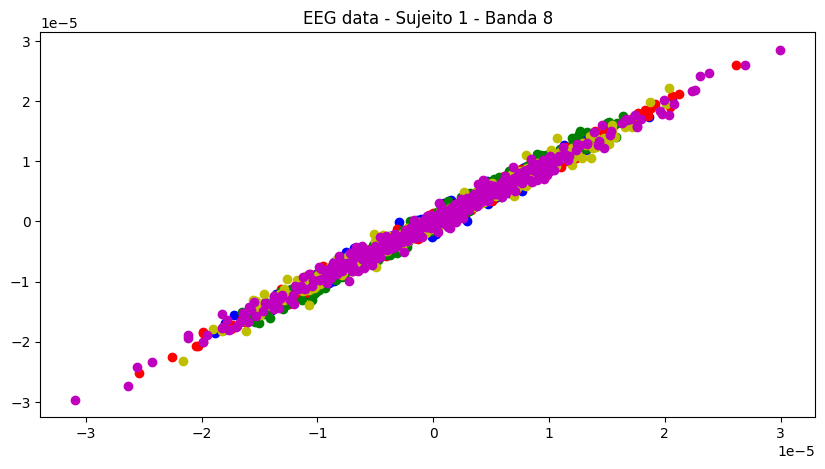

Banda:  9


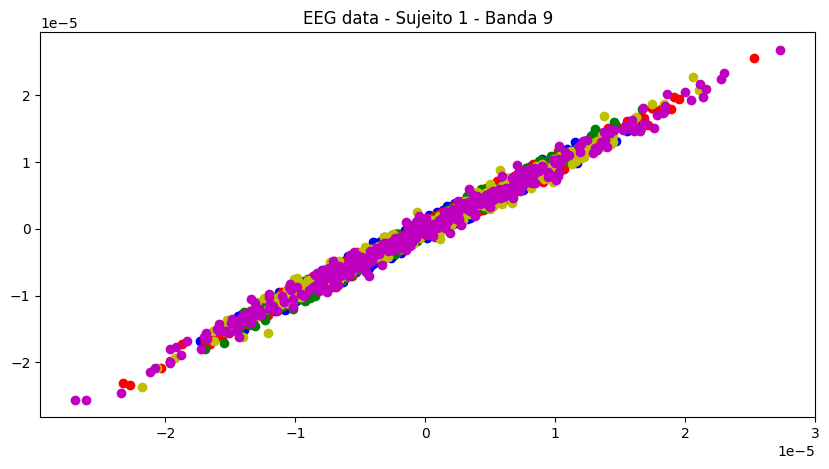

Banda:  10


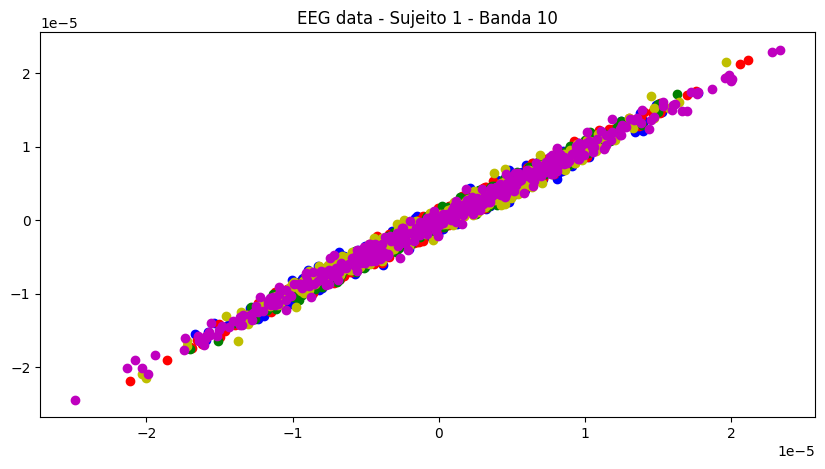

Banda:  11


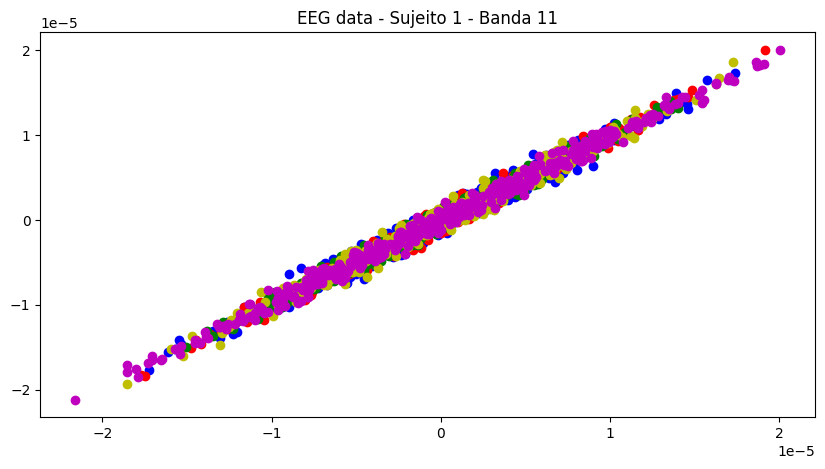

Banda:  12


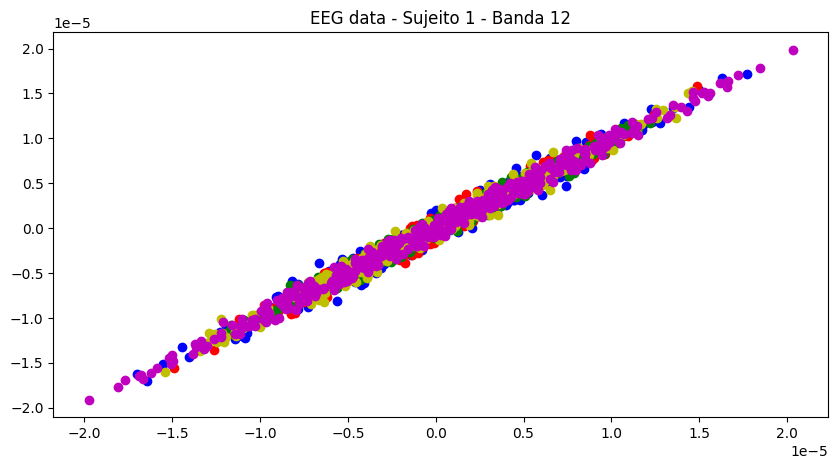

Banda:  13


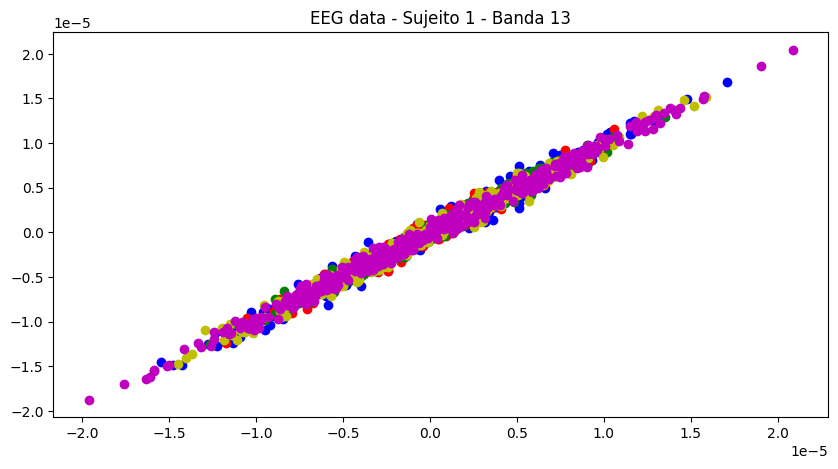

Banda:  14


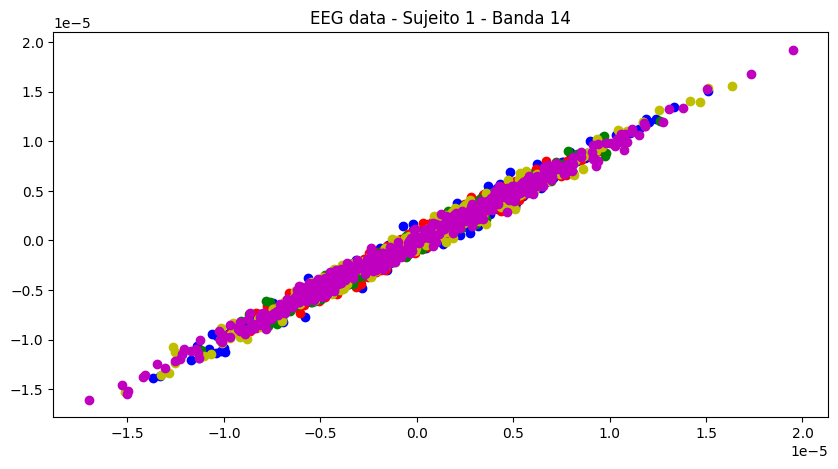

Banda:  15


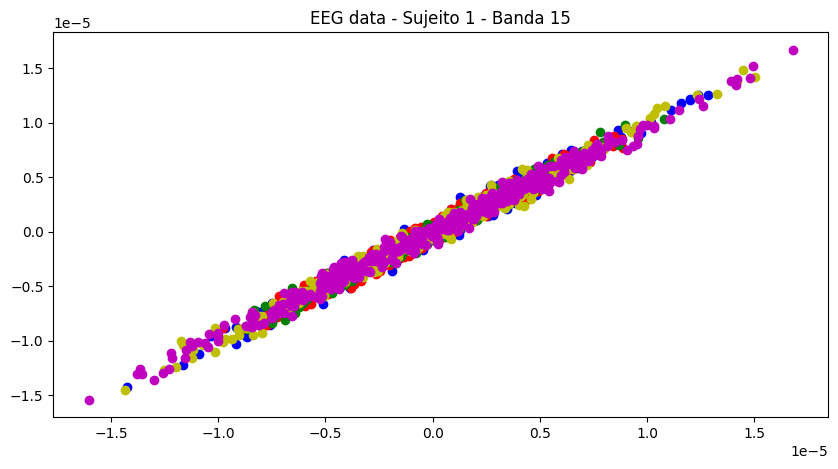

Banda:  16


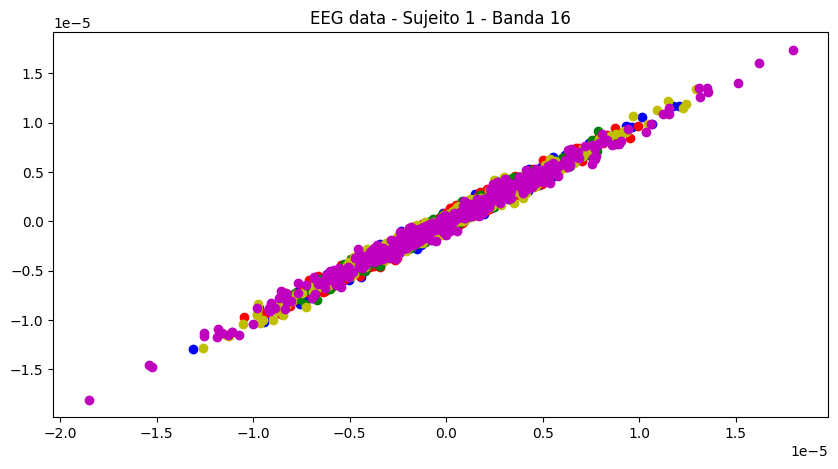

Banda:  17


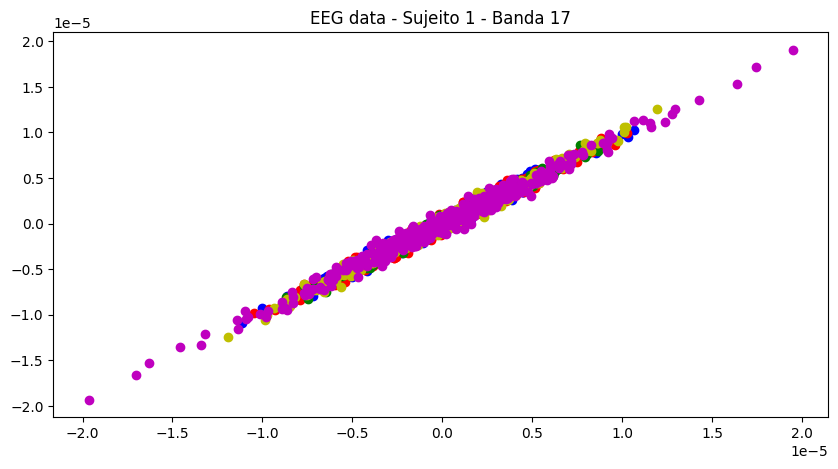

In [16]:
import matplotlib.pyplot as plt
colors = ['b', 'r', 'g', 'y', 'm']

subject = 0
print("Sujeito: ", subject+1)

for band in range(len(bands)):
    print("Banda: ", band+1)
    plt.figure(figsize=(10, 5))
    for class_ in range(5):
        # for i in range(all_train_data[subject][band][0][0].shape[0]): 
        #     plt.plot(all_train_data[subject][band][0][0][i])
        plt.scatter(all_train_data[subject][band][class_][0][0], all_train_data[subject][band][class_][0][2], color = colors[class_])
    plt.title(f"EEG data - Sujeito {subject+1} - Banda {band+1}")
    plt.show()



In [17]:
def train_CSP(X, Y, num_filters):
    X -= np.mean(X, axis=2)[:, :, np.newaxis]

    num_classes = len(np.unique(Y))

    covariances = []
    for i in range(num_classes):
        X_class = X[Y == i]
        S_class = np.mean([np.matmul(X_class[j], X_class[j].T) for j in range(X_class.shape[0])], axis=0)
        covariances.append(S_class)

    S0 = covariances[0]
    S1 = covariances[1]

    d, V = la.eigh(S0, S0 + S1)

    # get order of eigenvalues
    idx = np.argsort(np.abs(d - 0.5))[::-1]

    # reorder the eigenvectors
    V = V[:, idx]

    # transpose
    W = V.T

    # compute the patterns
    pattern = np.linalg.pinv(V)

    #select the two most important filters
    W = W[: num_filters]

    return W


def apply_csp(X, W, mean_power=False):
    X_csp = np.asarray([np.dot(W, epoch) for epoch in X])
    if mean_power:
        X_csp = (X_csp**2).mean(axis=2)
    
    return X_csp

In [18]:
def preprocess(X, W):
    X = 1/np.sqrt(X.shape[2]) * X @ (np.identity(X.shape[2]) - np.ones((X.shape[2], X.shape[2])) @ np.ones((X.shape[2], X.shape[2]))) #whitening
    
    X_csp = apply_csp(X, W)

    power = []

    for id in range(X_csp.shape[0]):
        x = X_csp[id, :,:]
        power.append(x @ x.T)

    power = np.diagonal(np.array(power), axis1=1, axis2=2)

    power = np.log(power)

    return power

In [19]:
#from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score as accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

J = 6
chosen_band = 1
chosen_class = 0

In [20]:
results = np.zeros((len(bands), 5, 2))

models = []
filters = []

for chosen_band in range(len(bands)):
    band_filters = []
    band_models = []
    for chosen_class in range(5):
        print(f"\n\nBand: {chosen_band+1},\nClass: {chosen_class+1}")

        X = all_train_data[subject][chosen_band]

        y = np.zeros(X.shape[0]* X.shape[1])
        for class_ in range(X.shape[0]):
            y[class_ * X.shape[1]: (class_ + 1) * X.shape[1]] = class_
        # print(y)

        X = X.reshape(-1, X.shape[2], X.shape[3])



        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        y_train = (y_train == chosen_class).astype(int)
        y_test = (y_test == chosen_class).astype(int)


        W = train_CSP(X_train, y_train, J)


        power = preprocess(X_train, W)

        # train the linear classifier
        clf = LDA()

        resampler = SMOTE()
        power, y_train = resampler.fit_resample(power, y_train)

        clf.fit(power, y_train)

        #train acc
        y_pred = clf.predict(power)
        print("train_acc",accuracy_score(y_train, y_pred))

        results[chosen_band, chosen_class, 0] = accuracy_score(y_train, y_pred)

        # test the classifier
        power_test = preprocess(X_test, W)
        y_pred = clf.predict(power_test)

        print("test_acc",accuracy_score(y_test, y_pred))
        results[chosen_band, chosen_class, 1] = accuracy_score(y_test, y_pred)
        band_filters.append(W)
        band_models.append(clf)
    models.append(band_models)
    filters.append(band_filters)



Band: 1,
Class: 1
train_acc 0.9545454545454546
test_acc 0.69


Band: 1,
Class: 2
train_acc 0.9285714285714286
test_acc 0.6293103448275862


Band: 1,
Class: 3
train_acc 0.8597560975609756
test_acc 0.5357142857142857


Band: 1,
Class: 4
train_acc 0.9036144578313252
test_acc 0.49425287356321834


Band: 1,
Class: 5
train_acc 0.8313253012048193
test_acc 0.7816091954022988


Band: 2,
Class: 1
train_acc 0.9204545454545454
test_acc 0.52


Band: 2,
Class: 2
train_acc 0.875
test_acc 0.6149425287356322


Band: 2,
Class: 3
train_acc 0.8780487804878049
test_acc 0.625


Band: 2,
Class: 4
train_acc 0.9096385542168675
test_acc 0.6293103448275862


Band: 2,
Class: 5
train_acc 0.8855421686746988
test_acc 0.6637931034482758


Band: 3,
Class: 1
train_acc 0.8977272727272727
test_acc 0.34


Band: 3,
Class: 2
train_acc 0.8511904761904763
test_acc 0.8275862068965517


Band: 3,
Class: 3
train_acc 0.8719512195121951
test_acc 0.5178571428571428


Band: 3,
Class: 4
train_acc 0.891566265060241
test_acc 0.8132183

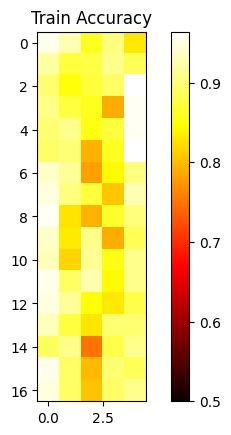

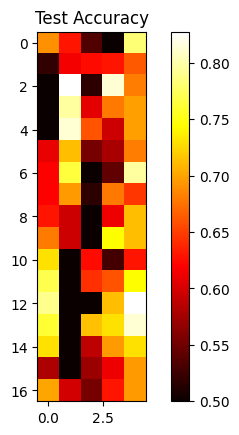

In [21]:
plt.imshow(results[:, :, 0], cmap='hot', interpolation='none', vmin=0.5)
plt.colorbar()
plt.title('Train Accuracy')
plt.show()

plt.imshow(results[:, :, 1], cmap='hot', interpolation='none', vmin=0.5)
plt.colorbar()
plt.title('Test Accuracy')
plt.show()

In [22]:
#for vizualization purposes, append all the trials in a single array, and aply a selected CSP filter
X = all_train_data[subject][chosen_band]
selected_class = 0
total_trials = np.zeros((J, 1))
long_y = []
print(X.shape)
for class_ in range(5):
    for trial in range(X.shape[1]):
        W = filters[chosen_band][selected_class]
        csp_x  = apply_csp(X[class_][trial][np.newaxis, :, :], W)[0]
        total_trials = np.append(total_trials, csp_x, axis=1)
        long_y+= [class_]*401

        print(total_trials.shape)

y_mask = np.array(long_y)

# for i in range(J):
#     plt.plot(total_trials[i])
#     plt.title(f"Filter {i}")

#     # y mask
#     for j in range(len(y_mask)):
#         if y_mask[j] == 0:
#             plt.axvline(x=j, color='b', alpha=0.005)
#         elif y_mask[j] == 1:
#             plt.axvline(x=j, color='r', alpha=0.005)
#         elif y_mask[j] == 2:
#             plt.axvline(x=j, color='g', alpha=0.005)
#         elif y_mask[j] == 3:
#             plt.axvline(x=j, color='y', alpha=0.005)
#         elif y_mask[j] == 4:
#             plt.axvline(x=j, color='m', alpha=0.005)

#     plt.show()


(5, 35, 16, 401)
(6, 402)
(6, 803)
(6, 1204)
(6, 1605)
(6, 2006)
(6, 2407)
(6, 2808)
(6, 3209)
(6, 3610)
(6, 4011)
(6, 4412)
(6, 4813)
(6, 5214)
(6, 5615)
(6, 6016)
(6, 6417)
(6, 6818)
(6, 7219)
(6, 7620)
(6, 8021)
(6, 8422)
(6, 8823)
(6, 9224)
(6, 9625)
(6, 10026)
(6, 10427)
(6, 10828)
(6, 11229)
(6, 11630)
(6, 12031)
(6, 12432)
(6, 12833)
(6, 13234)
(6, 13635)
(6, 14036)
(6, 14437)
(6, 14838)
(6, 15239)
(6, 15640)
(6, 16041)
(6, 16442)
(6, 16843)
(6, 17244)
(6, 17645)
(6, 18046)
(6, 18447)
(6, 18848)
(6, 19249)
(6, 19650)
(6, 20051)
(6, 20452)
(6, 20853)
(6, 21254)
(6, 21655)
(6, 22056)
(6, 22457)
(6, 22858)
(6, 23259)
(6, 23660)
(6, 24061)
(6, 24462)
(6, 24863)
(6, 25264)
(6, 25665)
(6, 26066)
(6, 26467)
(6, 26868)
(6, 27269)
(6, 27670)
(6, 28071)
(6, 28472)
(6, 28873)
(6, 29274)
(6, 29675)
(6, 30076)
(6, 30477)
(6, 30878)
(6, 31279)
(6, 31680)
(6, 32081)
(6, 32482)
(6, 32883)
(6, 33284)
(6, 33685)
(6, 34086)
(6, 34487)
(6, 34888)
(6, 35289)
(6, 35690)
(6, 36091)
(6, 36492)
(6, 3689

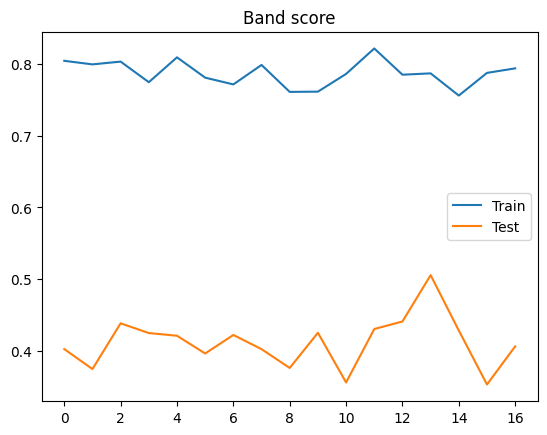

Ranking das bandas:  [13 12  2 11 14  9  3  6  4 16  0  7  5  8  1 10 15]


In [23]:
band_score = np.mean(results**2, axis=1)

# var plot of band scores
plt.plot(band_score[:, 0], label='Train')
plt.plot(band_score[:, 1], label='Test')
plt.legend()
plt.title('Band score')
plt.show()


# rank bands based on test accuracy
rank = np.argsort(band_score[:, 1])[::-1]
print("Ranking das bandas: ", rank)

In [35]:
from sklearn.cluster import AffinityPropagation

for chosen_class in range(5):
    all_filters = []
    X = all_train_data[subject]
    print(X.shape)

    X = X.transpose(1, 2, 0, 3, 4)
    X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3], X.shape[4])



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_test = X_test.transpose(1, 0, 2, 3)

    X_train = X_train.transpose(1, 2, 3, 0)
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2] * X_train.shape[3])

    for band in range(len(bands)):
        for filter in range(len(filters[band])):
            X_csp = X_train[band]
            X_csp = apply_csp(X_train[band], filters[filter][chosen_class])
            all_filters.append(X_csp[0])

    all_filters = np.array(all_filters)
    all_filters = all_filters.transpose(0, 2, 1).reshape(all_filters.shape[0], all_filters.shape[2] * all_filters.shape[1])
    clustering = AffinityPropagation(random_state = 0).fit(all_filters)
    #print(clustering.cluster_centers_)
    print(chosen_class, "LEN", len(clustering.cluster_centers_))

    # Ele escolheu os centros (que fazem parte do all_filters que lhe demos), agora  é preciso identificar qual é qual 

    selected_filters = []
    for center in clustering.cluster_centers_:
        min_dist = float('inf')
        selected_filter = 0
        for i, filter in enumerate(all_filters):
            dist = np.linalg.norm(center - filter)
            if dist < min_dist:
                min_dist = dist
                selected_filter = i
        selected_filters.append(selected_filter)

    selected_filters = [[(f//len(filters[band])), (f%len(filters[band]))] for f in selected_filters]
    selected_filters = np.array(selected_filters)
    print(selected_filters)


(17, 5, 35, 16, 401)
0 LEN 20
[[ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 8  0]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [13  0]
 [13  1]
 [13  2]
 [13  3]
 [13  4]]
(17, 5, 35, 16, 401)
1 LEN 20
[[ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 8  0]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [13  0]
 [13  1]
 [13  2]
 [13  3]
 [13  4]]
(17, 5, 35, 16, 401)
2 LEN 21
[[ 0  3]
 [ 0  4]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  4]
 [ 3  3]
 [ 3  4]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 8  0]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [13  0]
 [13  1]
 [13  2]
 [13  3]
 [13  4]]
(17, 5, 35, 16, 401)
3 LEN 20
[[ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 8  0]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [13  0]
 [13  1]
 [13  2]
 [13  3]
 [13  4]]
(17, 5, 35, 16, 401)
4 LEN 20
[[ 0  3]
 [ 0  4]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 3  4]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 8  0]
 [ 8  1]
 [ 8  2]


In [25]:
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0], 
              [4,3]])
clustering = AffinityPropagation(random_state=5).fit(X)
print(clustering.cluster_centers_)

[[1 2]
 [4 2]]


(17, 5, 35, 16, 401)
(175, 17, 16, 401)
(175,)
(105,)
(105, 1)
Train accuracy:  0.9236954860995781
Validation accuracy:  0.4904761904761905
Test accuracy:  0.5299999999999999


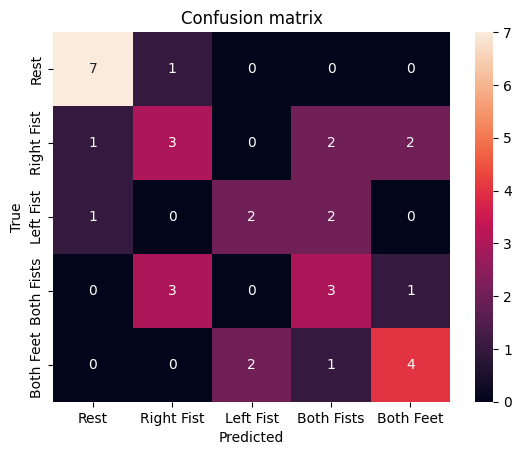

In [26]:
n_bands = 6

selected_bands = rank[:n_bands] #mau porque o treino é sempre bom, e escolher com base no teste é batota
#selected_bands = [15, 13, 2, 5, 4]

def classify(X_input, models, filters, accs_matrix = None):
    y_pred = []

    for chosen_band in selected_bands:
        for class_ in range(5):

            X = X_input[chosen_band]
            model = models[chosen_band][class_]
            W = filters[chosen_band][class_]

            X = preprocess(X, W)

            y_pred_model = model.predict(X)
            
            y_pred.append(y_pred_model)

    y_pred_5_classes = np.zeros((len(y_pred[1]), 5))

 
    if accs_matrix is not None:
        for idx in range(len(y_pred)):  
            yy = np.array(y_pred[idx])
            y_pred_5_classes[:, idx%5] += yy * accs_matrix[0] + (1-yy[0])*(1-accs_matrix[0]) 
    else:
        for idx in range(len(y_pred)): 
            y_pred_5_classes[:, idx%5] += y_pred[idx]



    y_pred_5_classes = np.argmax(y_pred_5_classes, axis=1).reshape(-1, 1)

    return y_pred_5_classes

X = all_train_data[subject]
print(X.shape)

X = X.transpose(1, 2, 0, 3, 4)
X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3], X.shape[4])

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_train = X_train.transpose(1, 0, 2, 3)
X_test = X_test.transpose(1, 0, 2, 3)
X_val = X_val.transpose(1, 0, 2, 3)


y_pred_5_classes = classify(X_train, models, filters)

# plt.imshow(y_pred_5_classes, aspect='auto', interpolation='none')
# plt.colorbar()
# plt.title('Predictions')
# plt.show()

print(y_train.shape)
print(y_pred_5_classes.shape)

print("Train accuracy: ", accuracy_score(y_train, y_pred_5_classes[:,0]))

y_pred_5_classes = classify(X_test, models, filters)
print("Validation accuracy: ", accuracy_score(y_test, y_pred_5_classes))


y_pred_5_classes = classify(X_val, models, filters)
print("Test accuracy: ", accuracy_score(y_val, y_pred_5_classes))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred_5_classes)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(5) + 0.5, ['Rest', 'Right Fist', 'Left Fist', 'Both Fists', 'Both Feet'])
plt.yticks(np.arange(5) + 0.5, ['Rest', 'Right Fist', 'Left Fist', 'Both Fists', 'Both Feet'])
plt.show()



In [27]:
acc_matrix = results[selected_bands, :, 1]
acc_matrix = acc_matrix.reshape(acc_matrix.shape[0]*acc_matrix.shape[1])


y_pred_5_classes = classify(X_val, models, filters, acc_matrix)
print("Test accuracy: ", accuracy_score(y_val, y_pred_5_classes))





Test accuracy:  0.6292857142857142


In [28]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)